In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

import utils.pc_utils as pc
import utils.distributions as dsts
import utils.imread_utils as imr

import imp
imp.reload(imr)

#jupyter notebook settings
#%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'dpi' : 200} #plotting pretty

In [3]:
p65folder = './images/places365/'
imfolder = p65folder+'val_large/'
imname = 'Places365_val_'

## Load in Image Metadata 

### Match Filenames to Category ID

In [4]:
colnames = ['filename','category_ID']
df_fname_cid = pd.read_table(p65folder+'places365_val.txt',sep=' ',header=None,names=colnames)
df_fname_cid.head(5)

filename  category_ID
0  Places365_val_00000001.jpg          165
1  Places365_val_00000002.jpg          358
2  Places365_val_00000003.jpg           93
3  Places365_val_00000004.jpg          164
4  Places365_val_00000005.jpg          289

### Match Category ID to Category Name

In [5]:
colnames = ['category','category_ID']
df_cat_cid = pd.read_table(p65folder+'categories_places365.txt',sep=' ',header=None,names=colnames)
df_cat_cid.head(5)

category  category_ID
0          /a/airfield            0
1    /a/airplane_cabin            1
2  /a/airport_terminal            2
3            /a/alcove            3
4             /a/alley            4

### Match Category Name to Indoor/Outdoor Manmade/Natural Labels

In [6]:
df_cat_lab = pd.read_csv(p65folder+'SceneHierarchy_Places365.csv', header=1)
df_cat_lab = df_cat_lab.iloc[:, 0:4] #don't need more specific than indoor/outdoor manmade/natural
df_cat_lab.head(5)

category  indoor  outdoor, natural  outdoor, man-made
0          '/a/airfield'       0                 0                  1
1    '/a/airplane_cabin'       1                 0                  0
2  '/a/airport_terminal'       1                 0                  0
3            '/a/alcove'       1                 0                  0
4             '/a/alley'       0                 0                  1

### Put these into one easy-to-use table together

In [7]:
df = pd.concat([df_cat_cid, df_cat_lab.iloc[:,1:]], axis=1)
df = pd.merge(df_fname_cid, df, on=['category_ID']).sort_values('filename')
df.head(5)

filename  category_ID              category  indoor  \
0    Places365_val_00000001.jpg          165  /g/greenhouse/indoor       1   
100  Places365_val_00000002.jpg          358            /w/wet_bar       1   
200  Places365_val_00000003.jpg           93         /c/clean_room       1   
300  Places365_val_00000004.jpg          164        /g/golf_course       0   
400  Places365_val_00000005.jpg          289          /r/rock_arch       0   

     outdoor, natural  outdoor, man-made  
0                   0                  0  
100                 0                  0  
200                 0                  0  
300                 1                  1  
400                 1                  0

## Some Example Images

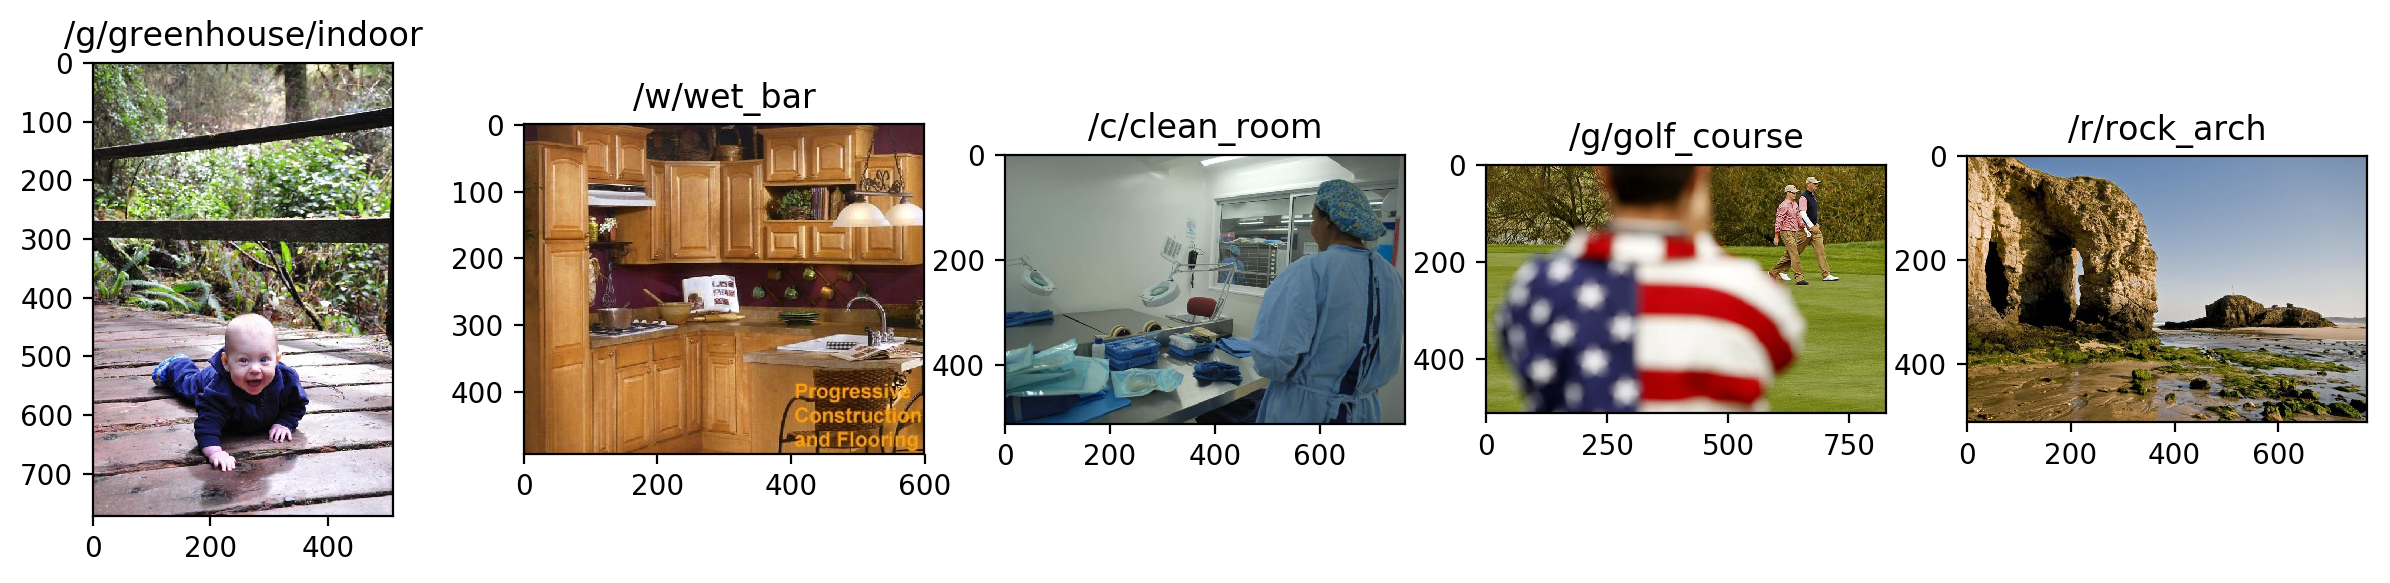

In [8]:
plt.figure(figsize=(15,3))
nims = 5

for imn in range(nims):
    imn = imn+1
    testim_fname = imname+'0000000'+str(imn)+'.jpg'
    testim = imr.readin_im(testim_fname, imfolder)
    testim_cat = df.loc[df['filename'] == testim_fname,'category'].item()
    #print(testim_cat)
    plt.subplot(1,nims,imn)
    plt.imshow(testim)
    plt.title(testim_cat)


## Get Indoor and Outdoor Images for Analysis

In [9]:
nims = 100 #only take a subset of the data

#Indoor Image Filenames
indoor_fnames = df.loc[df['indoor'] == 1] #labeled as indoor
indoor_fnames = indoor_fnames.loc[(indoor_fnames['outdoor, natural'] == 0) & \
                       (indoor_fnames['outdoor, man-made'] == 0)] #not labeled as outdoor  
indoor_fnames = np.array(indoor_fnames['filename'].sample(n=nims,replace=False)) #first n

#Outdoor Manmade Image Filenames
outdoorman_fnames = df.loc[(df['outdoor, natural'] == 0) & \
                       (df['outdoor, man-made'] == 1)]
outdoorman_fnames = outdoorman_fnames.loc[outdoorman_fnames['indoor'] == 0] # not labeled as indoor
outdoorman_fnames = np.array(outdoorman_fnames['filename'].sample(n=nims,replace=False)) #first n

#Outdoor Natural Image Filenames
outdoornat_fnames = df.loc[(df['outdoor, natural'] == 1) & \
                       (df['outdoor, man-made'] == 0)]
outdoornat_fnames = outdoornat_fnames.loc[outdoornat_fnames['indoor'] == 0] #not labeled as indoor
outdoornat_fnames = np.array(outdoornat_fnames['filename'].sample(n=nims,replace=False)) #first n

#readin images (preprocessing included but NO cosine window)
indoor_ims = [imr.readpreprc_im(fname,imfolder,cosine=False) for fname in indoor_fnames]
outdoorman_ims = [imr.readpreprc_im(fname,imfolder,cosine=False) for fname in outdoorman_fnames]
outdoornat_ims = [imr.readpreprc_im(fname,imfolder,cosine=False) for fname in outdoornat_fnames]

#control A: 1/f amplitude, random phase images
controlim_shape = (500,800) #approximately same as dataset
onef_ims = [dsts.make_onef_ims(controlim_shape, alpha=1, k=1) for i in range(nims)]

#control B: uniform random images
random_ims = [np.random.rand(*controlim_shape) for i in range(nims)]

Text(0.5,1,'random noise')

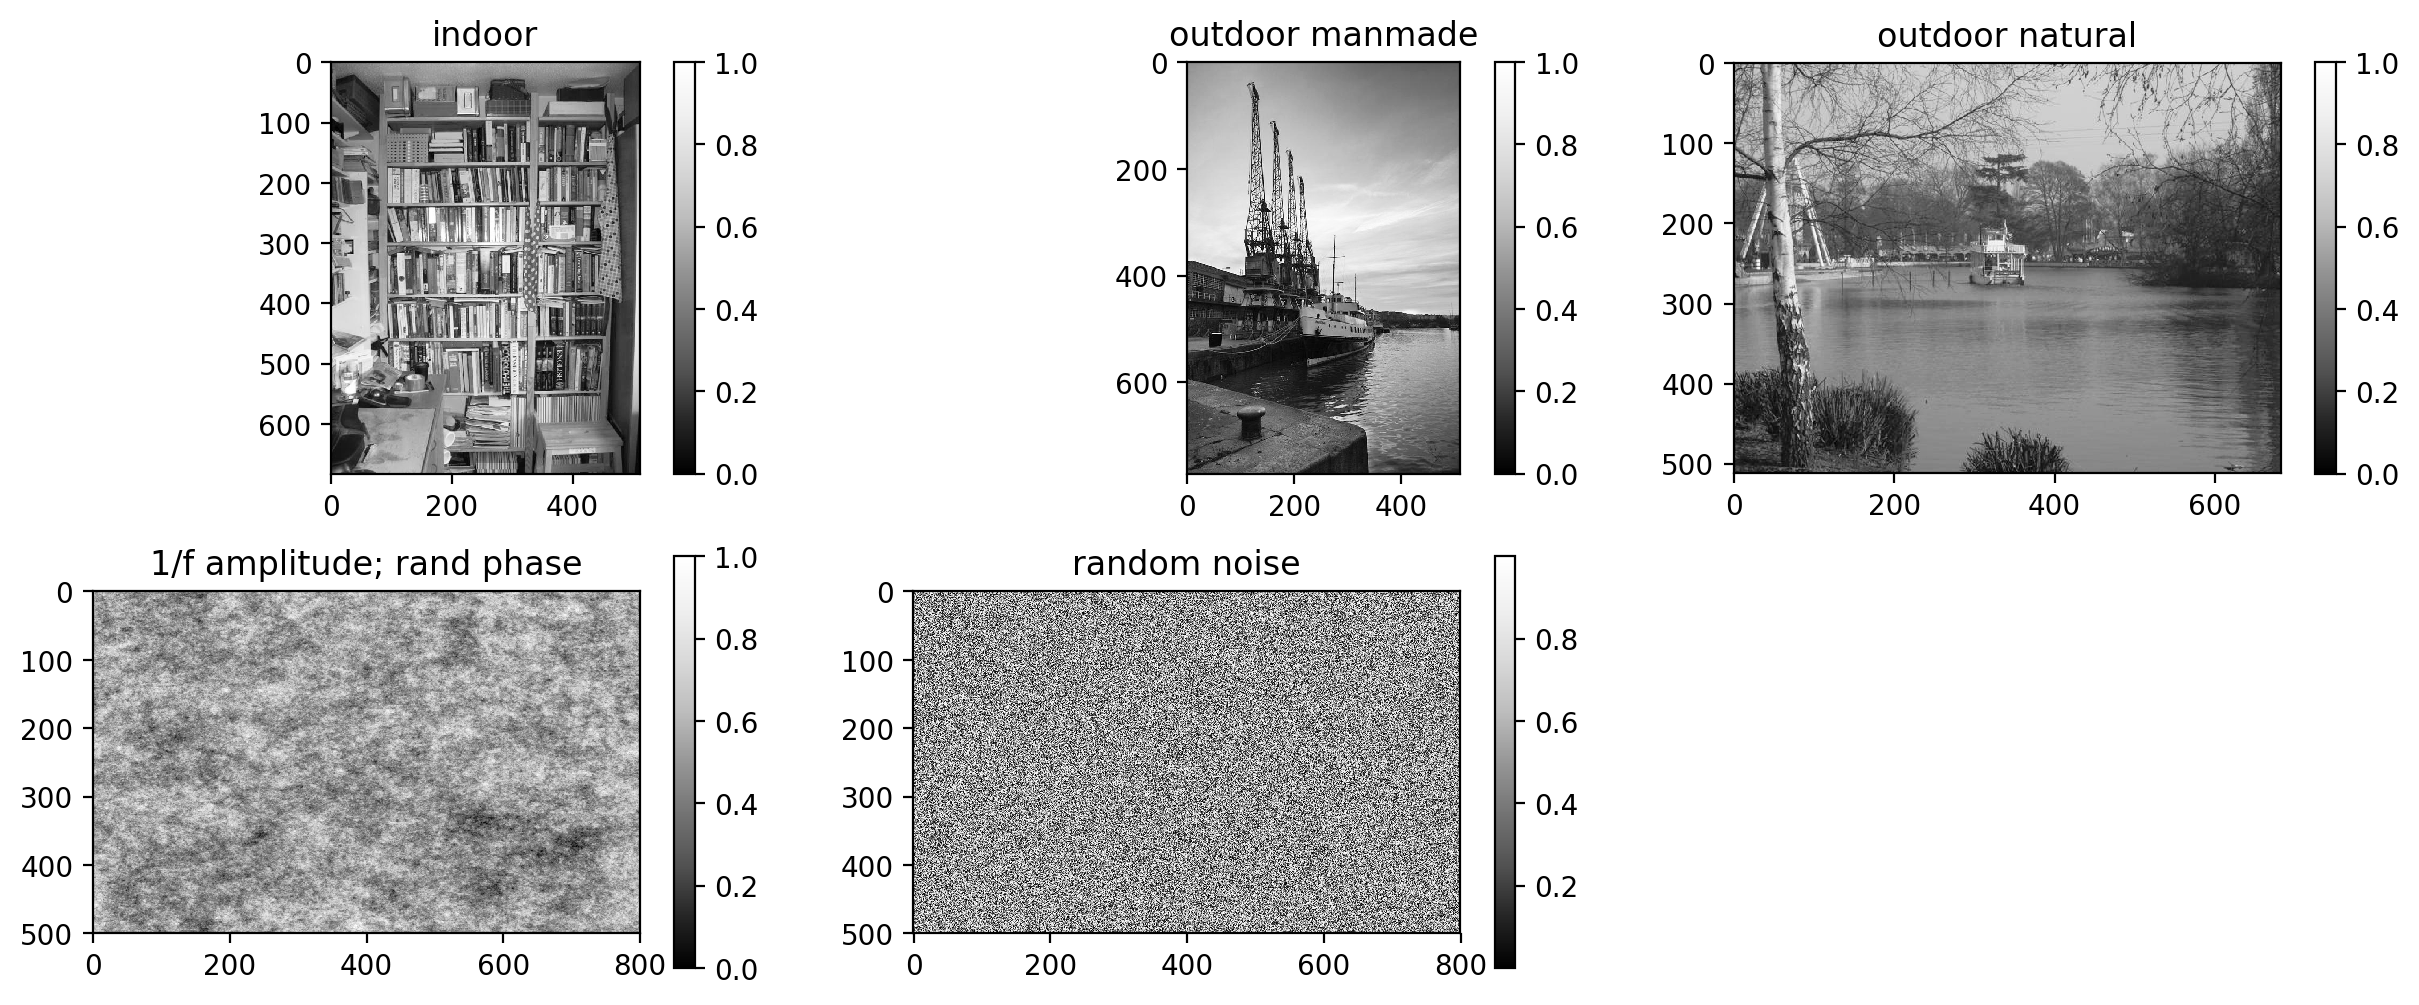

In [10]:
imnnum = 18
plt.figure(figsize=(15,6))
plt.subplot(2,3,1)
plt.imshow(indoor_ims[imnnum],cmap='Greys_r')
plt.colorbar()
plt.title('indoor')
plt.subplot(2,3,2)
plt.imshow(outdoorman_ims[imnnum],cmap='Greys_r')
plt.colorbar()
plt.title('outdoor manmade')
plt.subplot(2,3,3)
plt.imshow(outdoornat_ims[imnnum],cmap='Greys_r')
plt.colorbar()
plt.title('outdoor natural')
plt.subplot(2,3,4)
plt.imshow(onef_ims[imnnum],cmap='Greys_r')
plt.colorbar()
plt.title('1/f amplitude; rand phase')
plt.subplot(2,3,5)
plt.imshow(random_ims[imnnum],cmap='Greys_r')
plt.colorbar()
plt.title('random noise')

### calcuate phase congruency directional mean for categories

In [11]:
if 'indoor_pc_v' not in locals():
    print('Calculating Indoor PC...')
    indoor_pc_v = [np.mean(pc.measure_pc_axis(im,axis=0)) for im in indoor_ims] 
    indoor_pc_h = [np.mean(pc.measure_pc_axis(im,axis=1)) for im in indoor_ims]
    indoor_pc_slope, indoor_pc_offset = np.polyfit(indoor_pc_h, indoor_pc_v, deg=1)

    print('Calculating Outdoor Manmade PC...')
    outdoorman_pc_v = [np.mean(pc.measure_pc_axis(im,axis=0)) for im in outdoorman_ims] 
    outdoorman_pc_h = [np.mean(pc.measure_pc_axis(im,axis=1)) for im in outdoorman_ims] 
    outdoorman_pc_slope, outdoorman_pc_offset = np.polyfit(outdoorman_pc_h, outdoorman_pc_v, deg=1)

    print('Calculating Outdoor Natural PC...')
    outdoornat_pc_v = [np.mean(pc.measure_pc_axis(im,axis=0)) for im in outdoornat_ims] 
    outdoornat_pc_h = [np.mean(pc.measure_pc_axis(im,axis=1)) for im in outdoornat_ims] 
    outdoornat_pc_slope, outdoornat_pc_offset = np.polyfit(outdoornat_pc_h, outdoornat_pc_v, deg=1)

    print('Calculating 1/f Noise PC...')
    onef_pc_v = [np.mean(pc.measure_pc_axis(im,axis=0)) for im in onef_ims]
    onef_pc_h = [np.mean(pc.measure_pc_axis(im,axis=1)) for im in onef_ims]
    onef_pc_slope, onef_pc_offset = np.polyfit(onef_pc_h, onef_pc_v, deg=1)

    print('Calculating Random Noise PC...')
    rand_pc_v = [np.mean(pc.measure_pc_axis(im,axis=0)) for im in random_ims]
    rand_pc_h = [np.mean(pc.measure_pc_axis(im,axis=1)) for im in random_ims]
    rand_pc_slope, rand_pc_offset = np.polyfit(rand_pc_h, rand_pc_v, deg=1)
    
    print('Done!')

Calculating Indoor PC...
Calculating Outdoor Manmade PC...
Calculating Outdoor Natural PC...
Calculating 1/f Noise PC...
Calculating Random Noise PC...
Done!


<function matplotlib.pyplot.tight_layout>

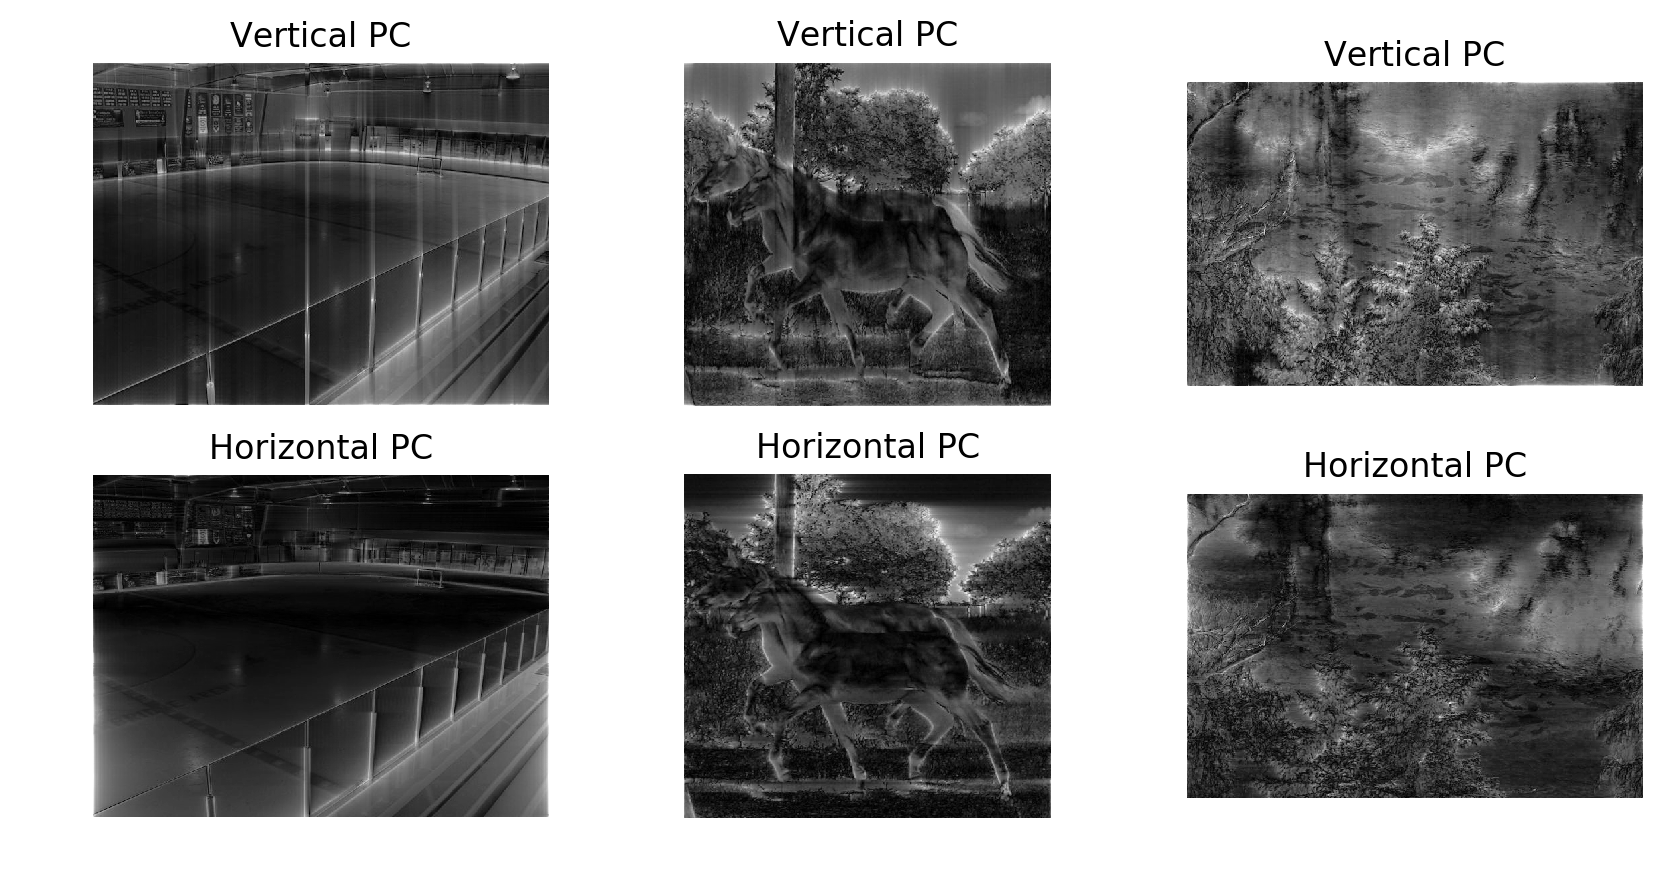

In [12]:
plt.figure(figsize=(10,5))

plt.subplot(2,3,1)
plt.imshow(pc.measure_pc_axis(indoor_ims[1],axis=0),cmap='Greys_r')
plt.title('Vertical PC')
plt.axis('off')
plt.subplot(2,3,4)
plt.imshow(pc.measure_pc_axis(indoor_ims[1],axis=1),cmap='Greys_r')
plt.title('Horizontal PC')
plt.axis('off')
plt.subplot(2,3,2)
plt.imshow(pc.measure_pc_axis(outdoorman_ims[1],axis=0),cmap='Greys_r')
plt.title('Vertical PC')
plt.axis('off')
plt.subplot(2,3,5)
plt.imshow(pc.measure_pc_axis(outdoorman_ims[1],axis=1),cmap='Greys_r')
plt.title('Horizontal PC')
plt.axis('off')
plt.subplot(2,3,3)
plt.imshow(pc.measure_pc_axis(outdoornat_ims[1],axis=0),cmap='Greys_r')
plt.title('Vertical PC')
plt.axis('off')
plt.subplot(2,3,6)
plt.imshow(pc.measure_pc_axis(outdoornat_ims[1],axis=1),cmap='Greys_r')
plt.title('Horizontal PC')
plt.axis('off')
plt.tight_layout

Text(0.5,1,'Mean Axial PC')

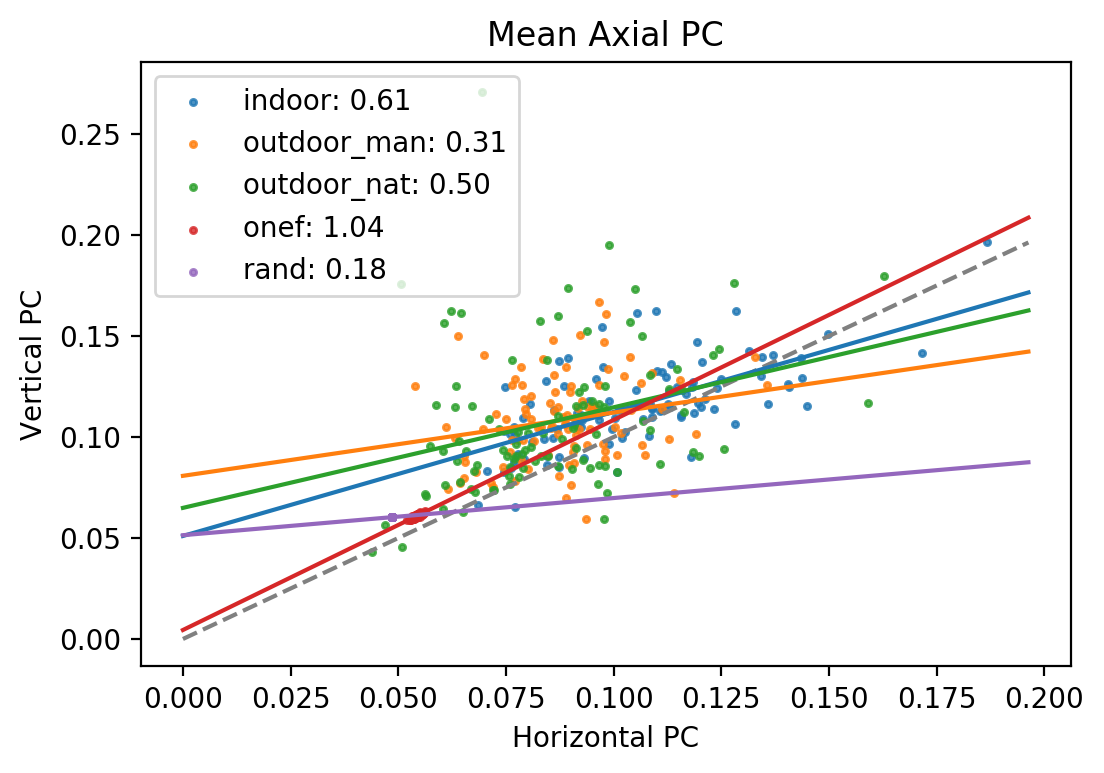

In [13]:
mxf = np.max(indoor_pc_v)
fran = np.linspace(0,mxf,100)

ss = 5
al = 0.8

#1:1 line
plt.plot(fran,fran,  c='grey', linestyle='--')

#indoor
plt.scatter(indoor_pc_h,indoor_pc_v,s=ss, alpha = al,
            label='indoor: {:.2f}'.format(np.mean(indoor_pc_slope)))
plt.plot(fran, fran*indoor_pc_slope+indoor_pc_offset)  

#outdoor manmade
plt.scatter(outdoorman_pc_h,outdoorman_pc_v,s=ss, alpha = al,
            label='outdoor_man: {:.2f}'.format(np.mean(outdoorman_pc_slope)))
plt.plot(fran, fran*outdoorman_pc_slope+outdoorman_pc_offset)

#outdoor natural
plt.scatter(outdoornat_pc_h,outdoornat_pc_v,s=ss, alpha = al,
            label='outdoor_nat: {:.2f}'.format(np.mean(outdoornat_pc_slope)))
plt.plot(fran, fran*outdoornat_pc_slope+outdoornat_pc_offset)

#1/f noise
plt.scatter(onef_pc_h,onef_pc_v,s=ss, alpha = al,
            label='onef: {:.2f}'.format(np.mean(onef_pc_slope)))
plt.plot(fran, fran*onef_pc_slope+onef_pc_offset)

#random
plt.scatter(rand_pc_h,rand_pc_v,s=ss, alpha = al,
            label='rand: {:.2f}'.format(np.mean(rand_pc_slope)))
plt.plot(fran, fran*rand_pc_slope+rand_pc_offset)

plt.xlabel('Horizontal PC')
plt.ylabel('Vertical PC')
plt.legend()
plt.title('Mean Axial PC')

#plt.gca().set_aspect('equal', adjustable='box')

Text(0.5,1,'Horizontal & Vertical Phase Congruency')

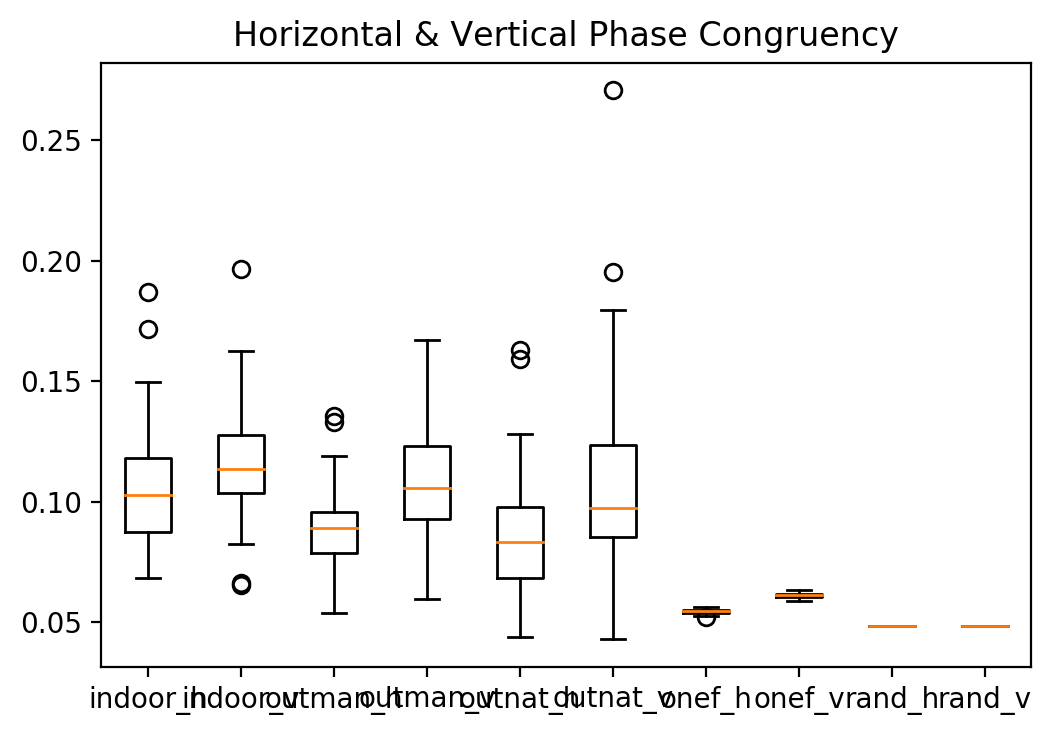

In [14]:
plt.boxplot((indoor_pc_h, indoor_pc_v,
             outdoorman_pc_h,outdoorman_pc_v,
             outdoornat_pc_h,outdoornat_pc_v,
             onef_pc_h, onef_pc_v,
             rand_pc_h, rand_pc_h),
           labels=('indoor_h', 'indoor_v',
                    'outman_h','outman_v',
                    'outnat_h','outnat_v',
                    'onef_h','onef_v',
                    'rand_h','rand_v'));

plt.title('Horizontal & Vertical Phase Congruency')

Text(0.5,1,'Total PC')

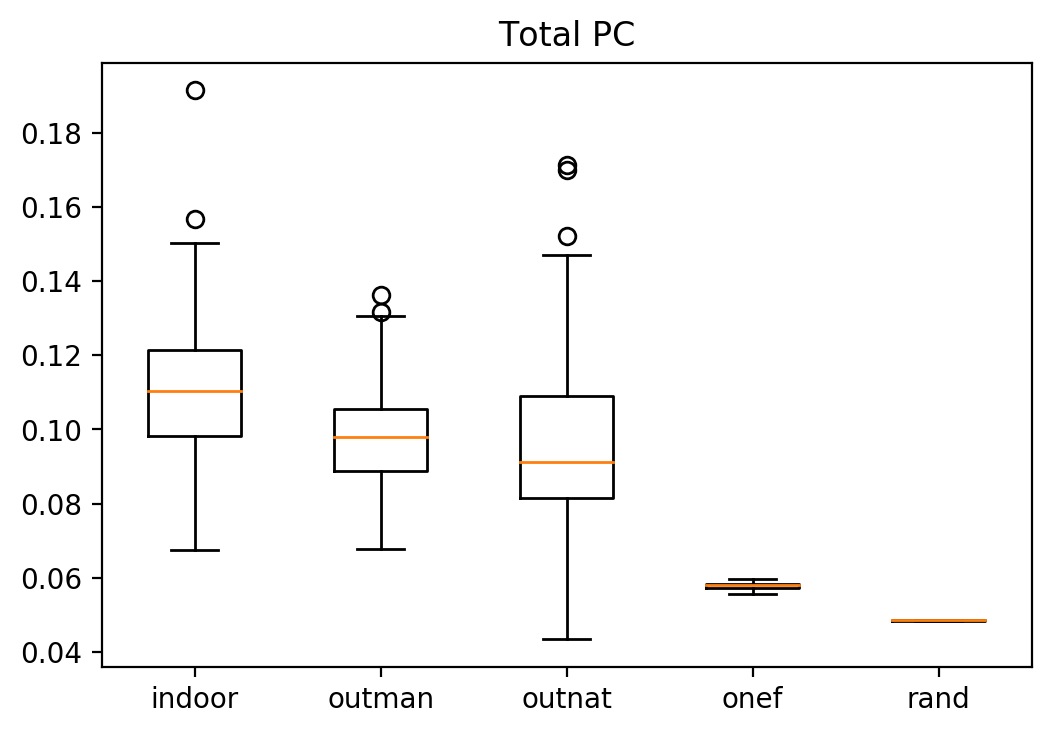

In [15]:
plt.boxplot((np.mean((indoor_pc_h, indoor_pc_v),axis=0),
             np.mean((outdoorman_pc_h,outdoorman_pc_v),axis=0),
             np.mean((outdoornat_pc_h,outdoornat_pc_v),axis=0),
             np.mean((onef_pc_h, onef_pc_v),axis=0),
             np.mean((rand_pc_h, rand_pc_h),axis=0)),
           labels=('indoor',
                    'outman',
                    'outnat',
                    'onef',
                    'rand'));

plt.title('Total PC')

In [16]:
Calculate entropy 

SyntaxError: invalid syntax (<ipython-input-16-b22b1b684f17>, line 1)